## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

## 加載音頻訊號

In [2]:
data_path = '/kaggle/input/recoding-data/UAV Recordings 3s/UAV Recordings 3s'

## 音頻訊號進行MFCCs特徵提取

In [3]:
def load_data(data_dir):
    datasets = []
    labels = []
    categories = os.listdir(data_dir)
    for index, folder in enumerate(categories):
        for filename in os.listdir(data_dir+"/"+folder):
            data, sampling_rate = librosa.load(data_dir+"/"+folder+"/"+filename)
            mfccs_features = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=80)
            mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
            datasets.append(np.array(mfccs_scaled_features))
            labels.append(categories[index])
    return np.array(datasets), np.array(labels)

datasets, labels = load_data(data_path)

In [4]:
datasets = datasets.astype('float32')

labelencoder = LabelEncoder()

labelsOneHot = to_categorical(labelencoder.fit_transform(labels))

## 切分成訓練資料、測試資料，8:2的比例

In [5]:
X_train, X_test, y_train, y_test = train_test_split(datasets, labelsOneHot, test_size = 0.2, stratify = labelsOneHot, random_state = 3)

print("----------Train-------------")
print(X_train.shape)

print("----------Test--------------")
print(X_test.shape)

----------Train-------------
(1504, 80)
----------Test--------------
(376, 80)


In [6]:
num_classes = len(np.unique(labels))

## 建立 Neural Network 模型

In [7]:
model=Sequential()

model.add(Dense(512, activation='relu', input_shape=(datasets.shape[1],)))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

# 使用Dropout防止過度擬合
model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_classes, activation='softmax'))

# 選擇損失函數、優化方法及成效衡量方式
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               41472     
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 115717 (452.02 KB)
Trainable params: 115717 (452.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 模型訓練

In [8]:
train_history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 100, epochs = 100, verbose=2)

Epoch 1/100
13/13 - 2s - loss: 2.5141 - accuracy: 0.3333 - val_loss: 1.2146 - val_accuracy: 0.6013 - 2s/epoch - 131ms/step
Epoch 2/100
13/13 - 0s - loss: 1.2053 - accuracy: 0.5245 - val_loss: 0.9629 - val_accuracy: 0.6578 - 77ms/epoch - 6ms/step
Epoch 3/100
13/13 - 0s - loss: 0.9410 - accuracy: 0.6434 - val_loss: 0.7039 - val_accuracy: 0.7375 - 73ms/epoch - 6ms/step
Epoch 4/100
13/13 - 0s - loss: 0.8009 - accuracy: 0.6858 - val_loss: 0.7576 - val_accuracy: 0.6578 - 71ms/epoch - 5ms/step
Epoch 5/100
13/13 - 0s - loss: 0.8554 - accuracy: 0.6600 - val_loss: 0.6428 - val_accuracy: 0.7508 - 83ms/epoch - 6ms/step
Epoch 6/100
13/13 - 0s - loss: 0.7156 - accuracy: 0.7165 - val_loss: 0.5498 - val_accuracy: 0.7973 - 72ms/epoch - 6ms/step
Epoch 7/100
13/13 - 0s - loss: 0.7106 - accuracy: 0.7257 - val_loss: 0.5671 - val_accuracy: 0.8106 - 71ms/epoch - 5ms/step
Epoch 8/100
13/13 - 0s - loss: 0.6310 - accuracy: 0.7573 - val_loss: 0.5261 - val_accuracy: 0.7674 - 72ms/epoch - 6ms/step
Epoch 9/100
13/1

## 評估訓練結果

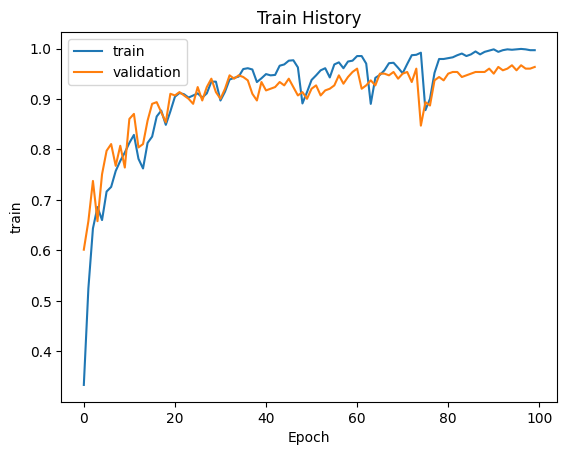

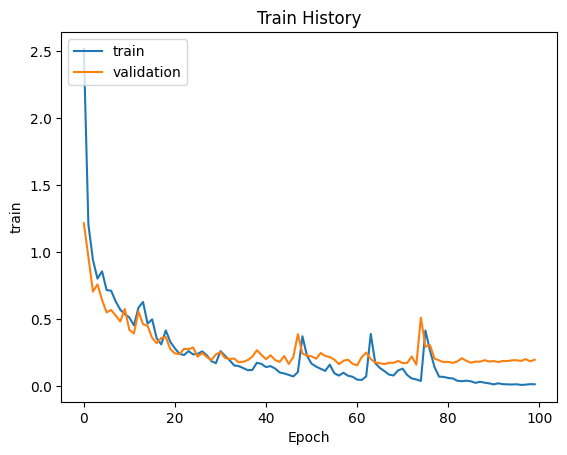

In [9]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])

    plt.plot(train_history.history[validation])

    plt.title('Train History')

    plt.ylabel('train')

    plt.xlabel('Epoch')

    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()
    

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

## 使用未參與訓練的測試資料測試，模型準確率

In [10]:
scores = model.evaluate(X_test,y_test,verbose=0)

print('Accuracy = ', scores[1])

Accuracy =  0.957446813583374


## 評估訓練結果

12/12 [==============================] - 0s 2ms/step


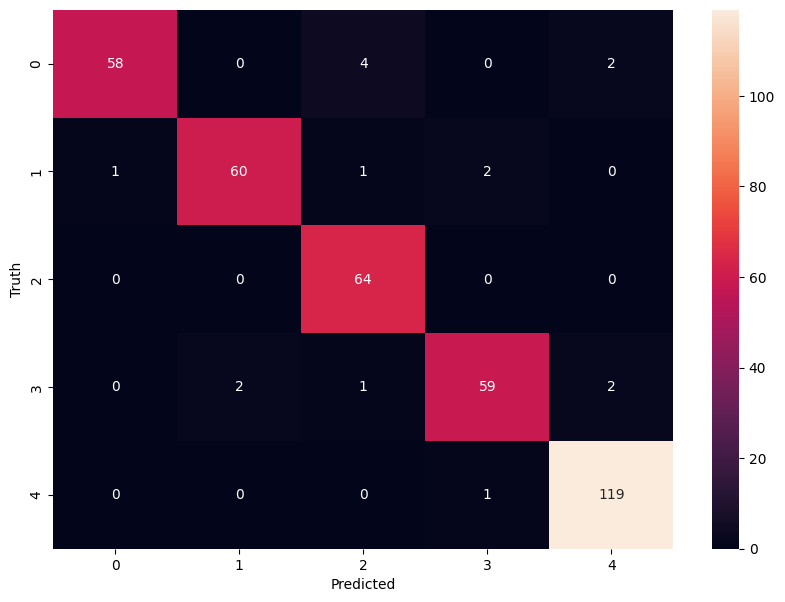

In [11]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()